In [1]:
# Import packages
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from PIL import Image
import cv2
import optuna
import pickle

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# Need to build my own pytorch dataset by pulling together all images from the 5 folders in train/test/val with their
# corresponding labels (0...4)
train_path = '/sc/arion/projects/shenl03_ml/2022_kevin_mammo/CBIS-DDSM_patch_set/train'
val_path = '/sc/arion/projects/shenl03_ml/2022_kevin_mammo/CBIS-DDSM_patch_set/val'
test_path = '/sc/arion/projects/shenl03_ml/2022_kevin_mammo/CBIS-DDSM_patch_set/test'


#train_img_paths = []
#classes = [] # should get a list of 5

def get_png_paths(path):
    img_paths = []
    classes = []
    
    for p, _, files in os.walk(path):
        for f in files:
            if '.png' in f:
                img_paths.append(os.path.join(p,f))
    return img_paths

train_img_paths = get_png_paths(train_path)
val_img_paths = get_png_paths(val_path)
test_img_paths = get_png_paths(test_path)

mammo_classes = {'background':0,
           'calc_ben':1,
           'calc_mal':2,
           'mass_ben':3,
           'mass_mal':4}

In [3]:
# Create a custom PyTorch Dataset with tuples of image array values and corresponding class represented as integer from mammo_classes dict
class MammoDataset(Dataset):
    def __init__(self,img_paths,transform):
        self.img_paths = img_paths
        self.transform = transform
        
    def __len__(self):
        return len(self.img_paths)
        
    def __getitem__(self, i):
        img_path = self.img_paths[i]
        img = cv2.imread(img_path)

        label = img_path.split('/')[-2] # retrieve label from folder above
        label = mammo_classes.get(label) #turn string label into integer
        if self.transform:
            # apply transformations
            # ToTensor() auto converts uint8 to range (0,1)
            img = self.transform(img)
        return img, label

In [4]:
# Add Normalize() to initial transforms
# ToTensor() converts uint8 values to range (0,1)
train_tf = transforms.Compose([
        transforms.ToTensor(), 
        transforms.RandomHorizontalFlip(.5), 
        transforms.RandomVerticalFlip(.5),  
        transforms.Normalize(0.3788,0.1508)
    ])

val_tf = transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize(0.3788,0.1508)
    ])

train_dataset = MammoDataset(train_img_paths,train_tf)
val_dataset = MammoDataset(val_img_paths,val_tf)
test_dataset = MammoDataset(test_img_paths,val_tf)

 # Make Dataloaders for each dataset
train_loader = DataLoader(train_dataset,batch_size=256,shuffle=True)
val_loader = DataLoader(val_dataset,batch_size=256,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=256,shuffle=False)


In [5]:
def accuracy(model,data_loader):
    correct = 0
    total = 0
    model.eval()
    # no gradients necessary when testing
    with torch.no_grad():
        for data in data_loader:
            images, labels = data[0].to(device), data[1].to(device)
            output = model(images)

            _, predicted = torch.max(output.data,1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        acc = 100*correct/total
        return acc

In [6]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 5)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0002)

epochs = 200
train_losses = []
val_losses = []
train_accs = []
val_accs = []
for epoch in range(epochs):

    train_loss = 0
    best_val_acc = -np.inf
    model.train()

    for i, data in enumerate(train_loader):

        # Retrieve inputs
        images, labels = data[0].to(device), data[1].to(device)

        #clear gradient
        optimizer.zero_grad()

        #forward step
        output = model(images)
        loss = criterion(output,labels)

        #backward step
        loss.backward()

        #optimize
        optimizer.step()
        train_loss += loss.item()
    
    train_losses.append(train_loss)
    train_acc_this_epoch = accuracy(model,train_loader)
    train_accs.append(train_acc_this_epoch)
    print("Training loss at Epoch {}: {}".format(epoch,train_loss))
    print("Training accuracy at Epoch {}: {}".format(epoch,train_acc_this_epoch))
    
    # Validation loss
    val_loss = 0.0
    total = 0
    correct = 0
    model.eval()
    for i, data in enumerate(val_loader):
        with torch.no_grad():
            inputs, labels = data[0].to(device), data[1].to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            loss = criterion(outputs, labels)
            val_loss += loss.item()
    val_losses.append(val_loss)
    val_acc_this_epoch = accuracy(model,val_loader)
    val_accs.append(val_acc_this_epoch)
    print("Validation loss at Epoch {}: {}".format(epoch,val_loss))
    print("Validation accuracy at Epoch {}: {}".format(epoch,val_acc_this_epoch))
    if val_acc_this_epoch > best_val_acc:
        best_val_acc = val_acc_this_epoch
        # If this model's val acc is best, save/overwrite best model for this trial
        torch.save(model.state_dict(),'./mammo_models/resnet18/mammo_class_resnet18_2.pth')
        
print("Finished Training")

/hpc/packages/minerva-centos7/py_packages/3.7/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Training loss at Epoch 0: 19.207152903079987
Training accuracy at Epoch 0: 65.16731855714906
Validation loss at Epoch 0: 4.017011523246765
Validation accuracy at Epoch 0: 62.5
Training loss at Epoch 1: 12.369175851345062
Training accuracy at Epoch 1: 76.31464580617123
Validation loss at Epoch 1: 3.3247823119163513
Validation accuracy at Epoch 1: 71.39423076923077
Training loss at Epoch 2: 9.366692036390305
Training accuracy at Epoch 2: 82.20338983050847
Validation loss at Epoch 2: 2.518315851688385
Validation accuracy at Epoch 2: 74.51923076923077
Training loss at Epoch 3: 7.8934729397296906
Training accuracy at Epoch 3: 85.44111255975663
Validation loss at Epoch 3: 2.406792640686035
Validation accuracy at Epoch 3: 75.60096153846153
Training loss at Epoch 4: 6.726925045251846
Training accuracy at Epoch 4: 86.24511082138201
Validation loss at Epoch 4: 2.82917320728302
Validation accuracy at Epoch 4: 74.75961538461539
Training loss at Epoch 5: 5.624214708805084
Training accuracy at Epoch

In [7]:
# Test network

model.load_state_dict(torch.load('./mammo_models/resnet18/mammo_class_resnet18_2.pth'))
model.eval()
test_acc = accuracy(model,test_loader)
print("Test set accuracy: {}".format(test_acc))

Test set accuracy: 78.21561338289963


In [8]:
# save train/val accs/losses
np.savez('mammo_class_resnet18_2.npz',train_losses=train_losses,val_losses=val_losses,train_accs=train_accs,val_accs=val_accs)

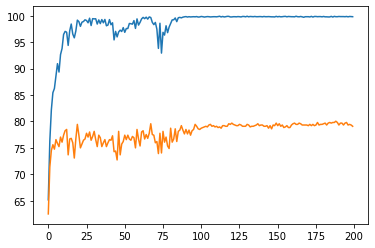

In [9]:
plt.plot(np.arange(0,200),train_accs)
plt.plot(np.arange(0,200),val_accs)

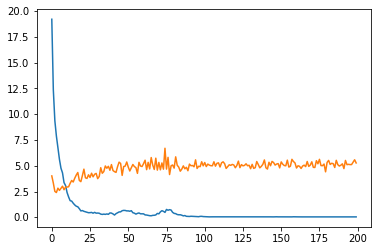

In [10]:
plt.plot(np.arange(0,200),train_losses)
plt.plot(np.arange(0,200),val_losses)